각 경로 마다 dbscan 수행

### 경로 데이터 불러오기


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

filenames = []
# CSV 파일에서 경로 데이터를 추출하는 함수
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filenames.append(filename)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
    return all_lat_lng_lists

# 경로 데이터를 읽어오는 경로 설정
directory_path = "../어디쉐어/어디쉐어 dbscan_NID"
lat_lng_values = extract_lat_lng_from_csv(directory_path)




### 경로 데이터 시각화 (입력 데이터)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

num_paths = len(lat_lng_values)

# tab20 컬러맵 사용하여 색상 생성
colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
np.random.shuffle(colors)  # 색상 리스트를 랜덤하게 섞어 인접한 색상이 유사하지 않게 함

plt.figure(figsize=(100, 60))

# 각 파일의 좌표 데이터를 다른 색상으로 시각화
for i, lat_lng_list in enumerate(lat_lng_values):
    lats, lngs = zip(*lat_lng_list)
    color = colors[i % len(colors)]  # 색상 리스트에서 순차적으로 색상 선택
    fn = filenames[i]
    plt.plot(lngs, lats, marker='o', color=color, label=f'Path {i+1},{fn} ', alpha=0.7)

plt.title("Latitude and Longitude Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(fontsize='x-small', loc='lower right')
plt.show()


### DBSCAN 모델로 이상치 판단 및 시각화 (출력 데이터)

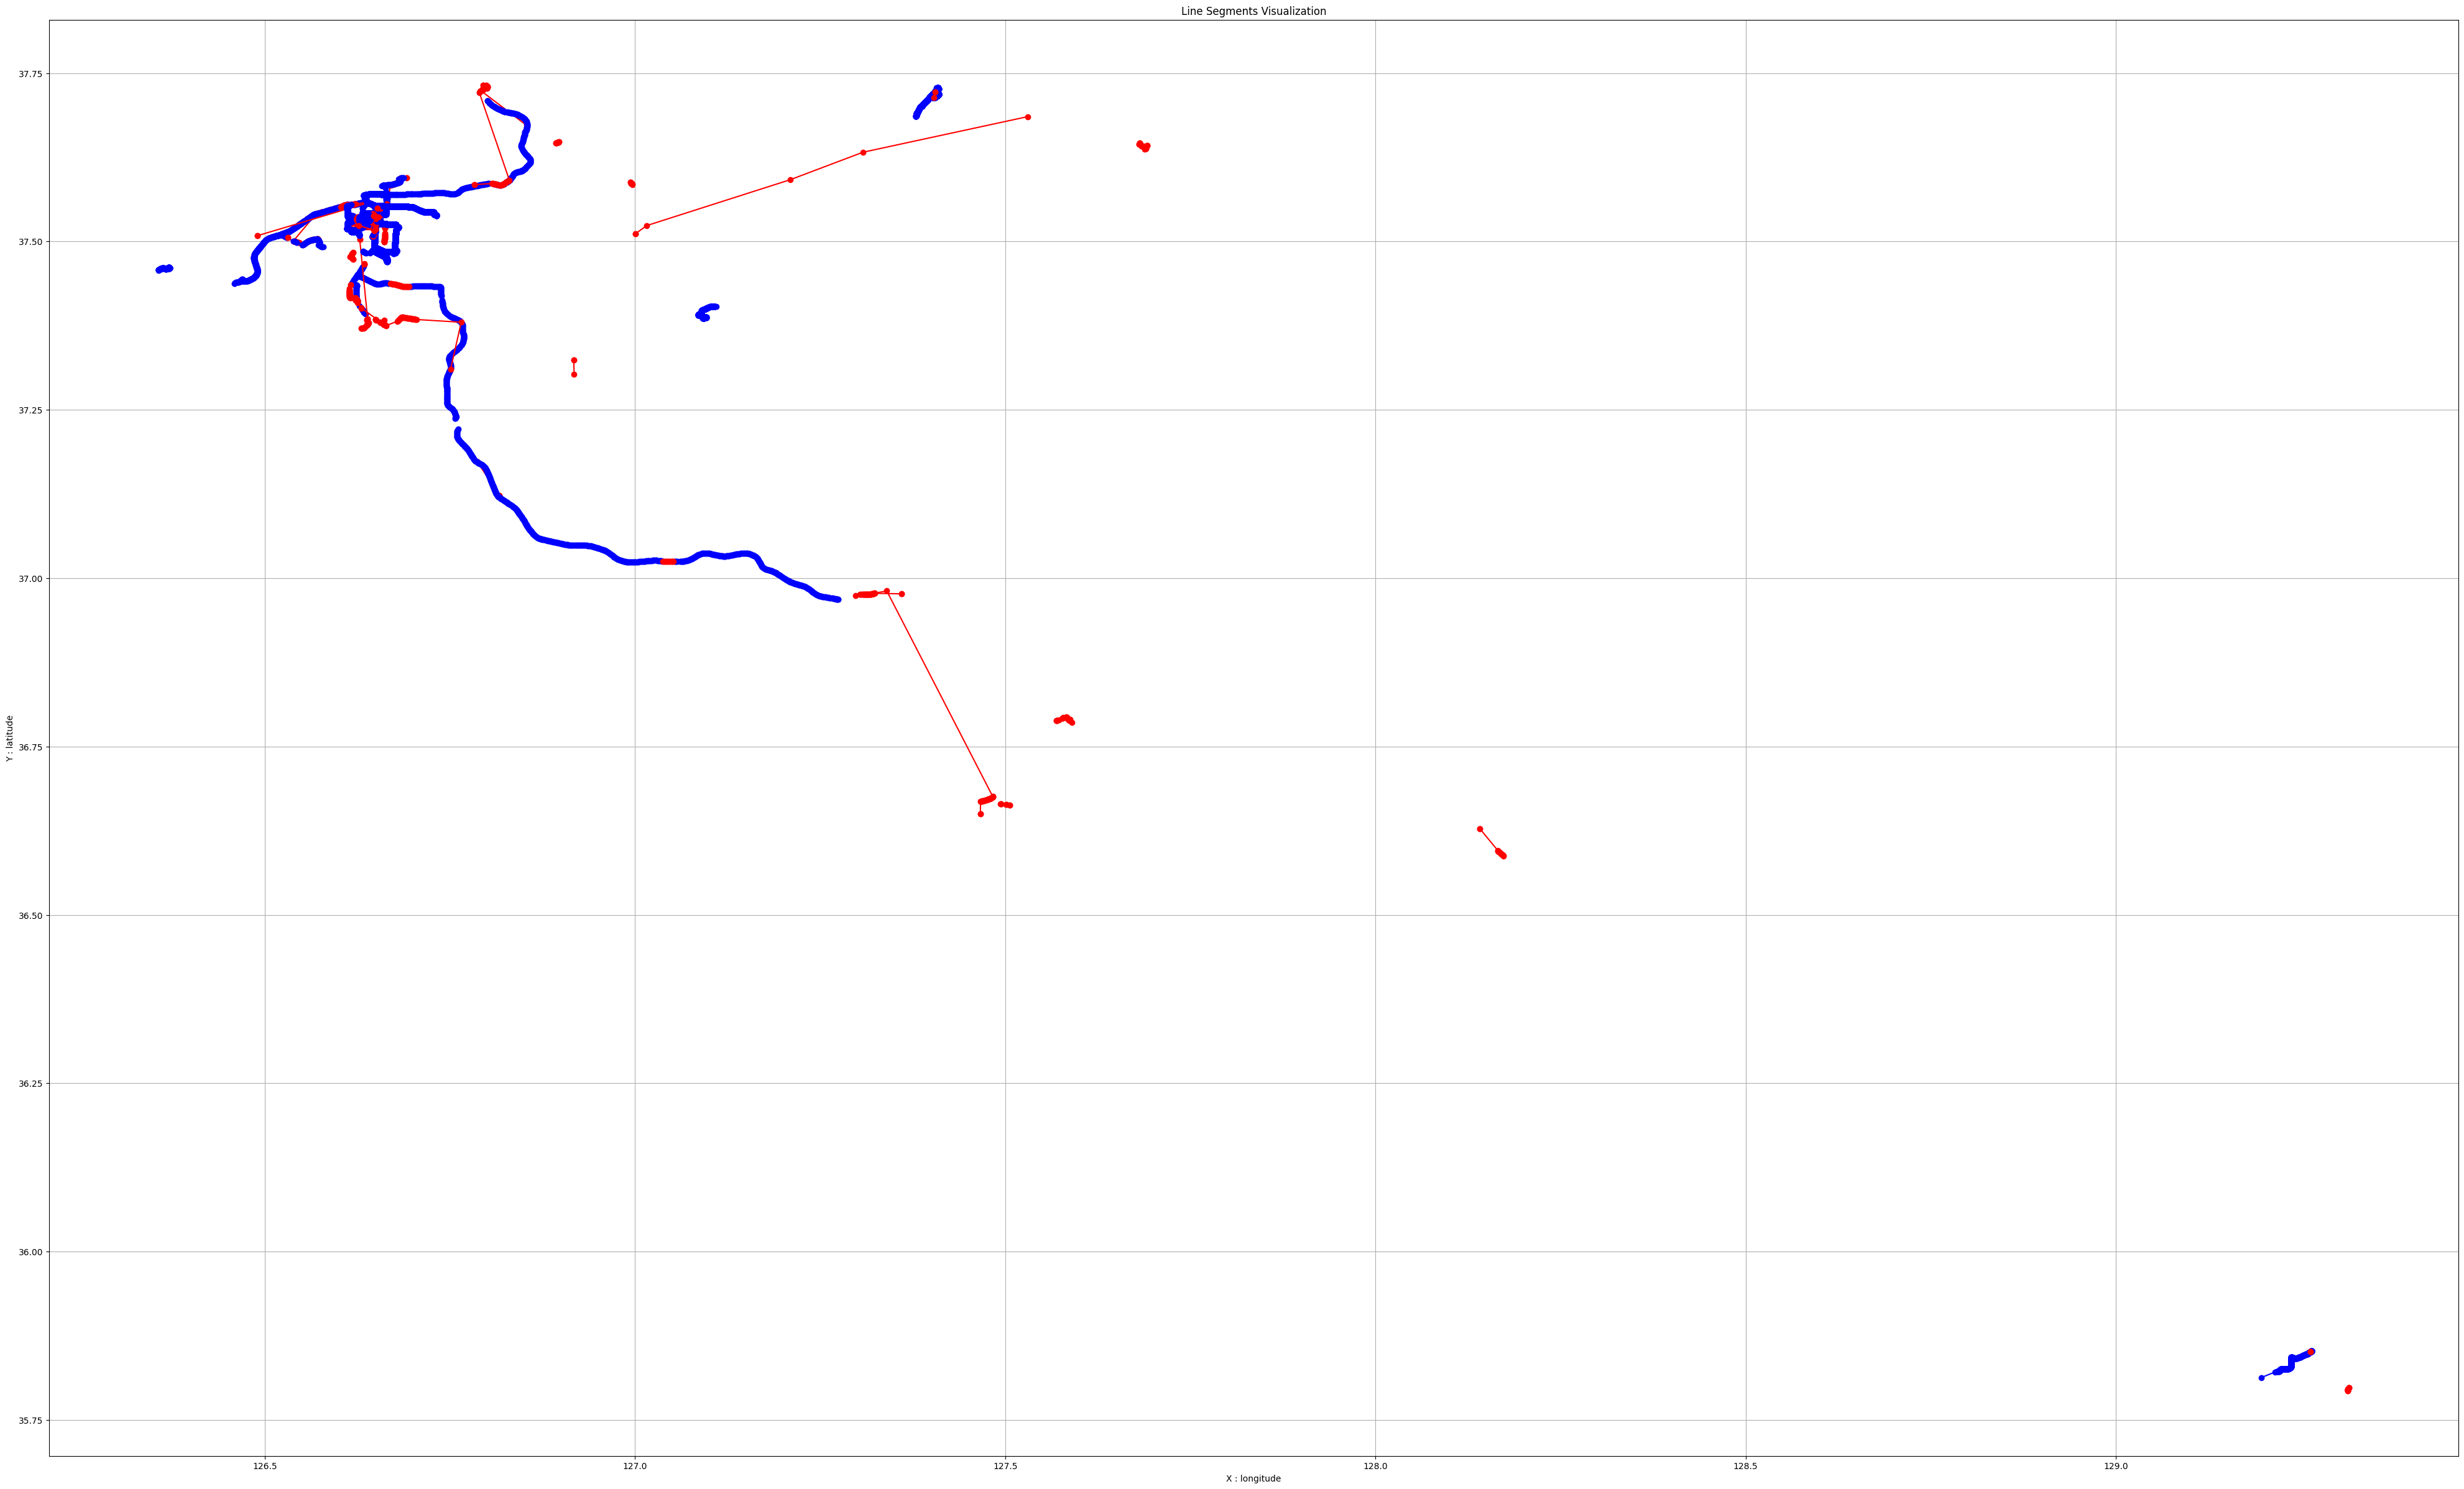

In [8]:
plt.figure(figsize=(50, 30))

for i, path in enumerate(lat_lng_values):
    path = np.array(path)
    dbscan = DBSCAN(eps=0.15, min_samples=4)
    labels = dbscan.fit_predict(path)

    # 클러스터링 결과 시각화
    for label in set(labels):
        label_mask = (labels == label)
        if label == -1:
            color = 'red'  # 노이즈 포인트
        else:
            color = 'blue'  # 클러스터 포인트
        plt.plot(path[label_mask, 1], path[label_mask, 0], marker='o', linestyle='-', color=color, label=f'Path {i+1}, Cluster {label}')

plt.title('Line Segments Visualization')
plt.xlabel('X : longitude')
plt.ylabel('Y : latitude')
plt.grid(True)
plt.show()

### 최적 파라미터 찾기

In [5]:
from sklearn.metrics import silhouette_score

def evaluate_dbscan(data, eps_values, min_samples_values):
    best_score = -1
    best_eps = None
    best_min_samples = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(set(labels)) > 1:  # 최소 두 개 이상의 클러스터가 필요
                score = silhouette_score(data, labels, metric='euclidean')
                print(f'eps={eps}, min_samples={min_samples}, silhouette_score={score}')
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    return best_eps, best_min_samples

# 예시 사용
eps_values = np.arange(0.01, 0.015, 0.05)
min_samples_values = range(20, 50, 5)
data = np.concatenate(lat_lng_values)  # 모든 데이터 포인트를 하나로 결합
best_eps, best_min_samples = evaluate_dbscan(data, eps_values, min_samples_values)

print(f'Best eps: {best_eps}, Best min_samples: {best_min_samples}')


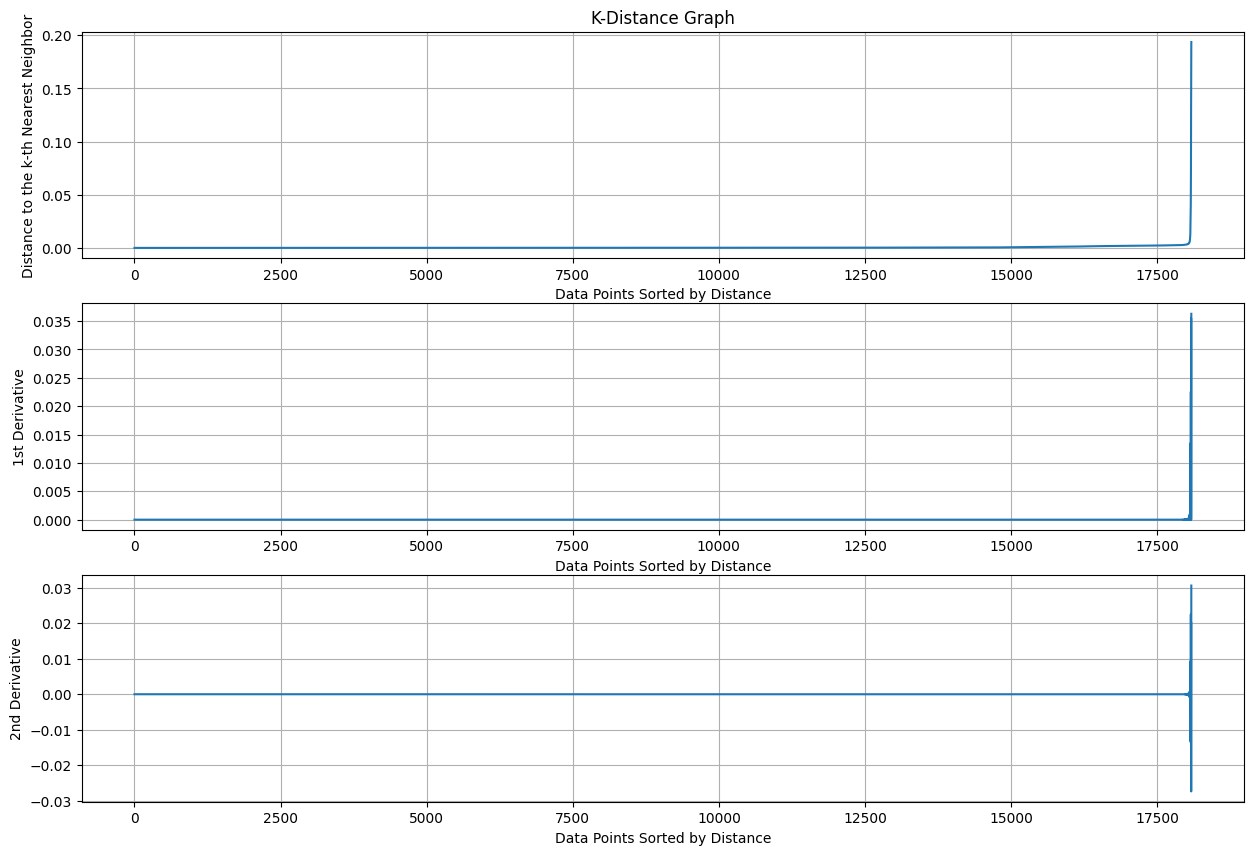

Optimal eps value: 0.15180295371302202


In [2]:
# import numpy as np
# import pandas as pd
# import os
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt

# def extract_lat_lng_from_csv(directory):
#     all_lat_lng_lists = []
#     for filename in os.listdir(directory):
#         if filename.endswith(".csv"):
#             filepath = os.path.join(directory, filename)
#             df = pd.read_csv(filepath)
#             lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
#             all_lat_lng_lists.append(lat_lng_list)
#     return np.concatenate(all_lat_lng_lists)  # 모든 데이터 포인트를 하나로 결합

# def plot_k_distance_graph(data, k):
#     # K번째 가까운 이웃까지의 거리 계산
#     neighbors = NearestNeighbors(n_neighbors=k)
#     neighbors.fit(data)
#     distances, _ = neighbors.kneighbors(data)
#     k_distances = np.sort(distances[:, -1], axis=0)  # K번째 거리 추출 및 정렬

#     # 1차 미분 계산
#     first_derivative = np.diff(k_distances)
    
#     # 2차 미분 계산
#     second_derivative = np.diff(first_derivative)

#     # 그래프 그리기
#     plt.figure(figsize=(15, 10))
#     plt.subplot(3, 1, 1)
#     plt.plot(k_distances)
#     plt.title('K-Distance Graph')
#     plt.xlabel('Data Points Sorted by Distance')
#     plt.ylabel('Distance to the k-th Nearest Neighbor')
#     plt.grid(True)

#     plt.subplot(3, 1, 2)
#     plt.plot(first_derivative)
#     plt.xlabel('Data Points Sorted by Distance')
#     plt.ylabel('1st Derivative')
#     plt.grid(True)

#     plt.subplot(3, 1, 3)
#     plt.plot(second_derivative)
#     plt.xlabel('Data Points Sorted by Distance')
#     plt.ylabel('2nd Derivative')
#     plt.grid(True)
#     plt.show()

#     # 엉덩이 지점 찾기
#     elbow_index = np.argmax(second_derivative)
#     return k_distances[elbow_index]

# # 데이터 경로 설정
# directory_path = "./어디쉐어/어디쉐어 dbscan"
# data = extract_lat_lng_from_csv(directory_path)

# # K-거리 그래프와 기울기 변화 분석
# optimal_eps = plot_k_distance_graph(data, k=5)
# print(f'Optimal eps value: {optimal_eps}')


### 이상치 여부를 원본 CSV 파일에 기록

In [7]:

# 이상치 여부를 'dbscan output' 열에 기록하는 함수

def record_outliers(directory, labels, filenames):
 
    for label, filename in zip(labels, filenames):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        if 'dbscan output' not in df.columns:
            df['dbscan output'] = 1  # 기본값 1로 설정
        if label == -1:
            df['dbscan output'] = -1  # 이상치일 경우 -1로 설정
        df.to_csv(filepath, index=False)

# 이상치 여부를 CSV 파일에 기록
record_outliers(directory_path, labels, filenames)